In [2]:
using Distributed
addprocs(8);

In [3]:
@everywhere using DrWatson

In [4]:
@everywhere @quickactivate "simple_smm"

      From worker 7:	  Activating project at `~/work/border-trade/simple_smm`


  Activating project at `~/work/border-trade/simple_smm`


      From worker 9:	  Activating project at `~/work/border-trade/simple_smm`
      From worker 2:	  Activating project at `~/work/border-trade/simple_smm`
      From worker 3:	  Activating project at `~/work/border-trade/simple_smm`
      From worker 8:	  Activating project at `~/work/border-trade/simple_smm`
      From worker 5:	  Activating project at `~/work/border-trade/simple_smm`
      From worker 4:	  Activating project at `~/work/border-trade/simple_smm`
      From worker 6:	  Activating project at `~/work/border-trade/simple_smm`


In [5]:
@everywhere begin
    using SMM
    using DataFrames
    using OrderedCollections
    using Random
    using Distributions
    using StatsBase
end

┌ Info: Precompiling SMM [bc769cb7-f249-5bba-802a-79f18cb247ec]
└ @ Base loading.jl:1662
┌ Info: Skipping precompilation since __precompile__(false). Importing SMM [bc769cb7-f249-5bba-802a-79f18cb247ec].
└ @ Base loading.jl:1341


In [6]:
using Plots, StatsPlots

In [7]:
@everywhere function calculate_moments(observed_data)
    Dict(
        :mean => mean(observed_data),
        :var => var(observed_data),
        :skew => skewness(observed_data)
    )
end

In [8]:
function create_moments_df(moments_dict, weights_dict)
    name = []
    value = []
    weight = []
    for k in keys(moments_dict)
        push!(name, k)
        push!(value, moments_dict[k])
        push!(weight, weights_dict[k])
    end
    
    return DataFrame(
        name=name,
        value=value,
        weight=weight
    )
end

create_moments_df (generic function with 1 method)

In [125]:
@everywhere function mymodel(; a, b, c)
    mu = c*(a - b) ^ 3 + 6
    sigma = (a*b + c) ^ 2
    # mu = a
    # sigma = c
    d = Normal(mu, sigma)
    rand(d)
end

calculate_moments(observed_data) = Dict(:mean => -103.34398222009325, :var => 28.019081950951822, :skew => -0.007852156939684392)


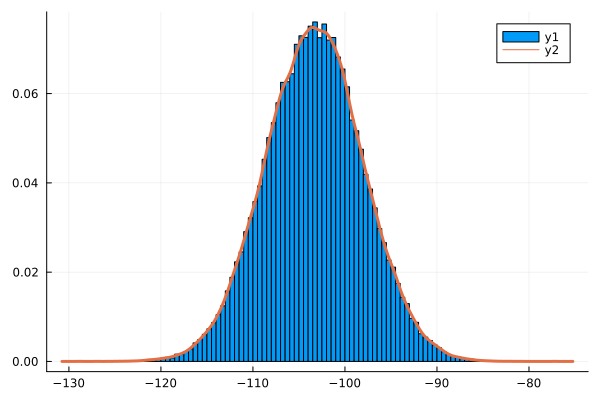

In [126]:
# true parameters (unobserved - want to estimate)
true_params = OrderedDict(:a => -1, :b => 3.5, :c => 1.2)
# Pretend that these are real observed data.
observed_data = [mymodel(; true_params...) for i in 1:100000]
@show calculate_moments(observed_data)
# Plot the observations
histogram(observed_data, bins=100, normalize=true)
density!(observed_data, lw=3)

Old norm

In [127]:
@everywhere begin
"""
    objfunc_norm(ev::Eval)
Test objective function. This is a bivariate normal distribution that simumlates data from the parameters in `ev`. From this simulated data, sample means are computed, which should be close to the empirical moments on `ev`. The aim is to minimize this function.
"""
function my_objfunc_norm(ev::Eval)
    start(ev)
    # info("in Test objective function objfunc_norm")

    # extract parameters    
    # mu  = convert(Array{Float64,1},param(ev)) # returns entire parameter vector 
    mu  = collect(values(ev.params))
    nm = length(ev.dataMoments)
    # use paramd(ev) to get as a dict.

    # compute simulated moments
    if get(ev.options,:noseed,false)

    else
        Random.seed!(1234)
    end
    ns = 10000
    sigma           = ones(nm)
    randMultiNormal = SMM.MvNormal(mu,SMM.PDiagMat(sigma)) 
    simM            = mean(rand(randMultiNormal,ns),dims = 2)
    # simMoments = Dict(:mu1 => simM[1], :mu2 => simM[2])

    # get data mometns
    # same thing here, and use dataMomentsWeights for sd
    # second argument can be optional
    # get objective value: (data[i] - model[i]) / weight[i]
    v = Dict{Symbol,Float64}()
    simMoments = Dict{Symbol,Float64}()
    i = 0
    for (k,mom) in dataMomentd(ev)
        i += 1
        simMoments[k] = simM[i]
        if haskey(SMM.dataMomentWd(ev),k)
            v[k] = ((simMoments[k] .- mom) ./ dataMomentW(ev,k)) .^2
            # v[k] = (simMoments[k] ./ mom .- 1.0) .^2    # true scale of all moments is 1.0
        else
            v[k] = ((simMoments[k] .- mom) ) .^2
            # v[k] = (simMoments[k] ./ mom .- 1.0) .^2
        end
    end
    setValue!(ev, mean(collect(values(v))))
    # value = data - model
    # setValue!(ev, mean((simMoments - trueMoments).^2) )

    # also return the moments
    setMoments!(ev, simMoments)
    # mdf = DataFrame(name=["m1","m2"],value=simMoments[:])
    # setMoments!(ev, mdf)

    ev.status = 1

    # finish and return
    finish(ev)

    return ev
end
end

new norm

In [111]:
@everywhere function mymodel_norm(ev::Eval)
    start(ev)

    # optionally set random seed
    if !get(ev.options,:noseed,false)
        Random.seed!(1234)
    end
    

    # Perform simulations and calculate moments of results
    num_sims = 50000
    simulated_data = [mymodel(; ev.params...) for i in 1:num_sims]
    simulated_moments = calculate_moments(simulated_data)

    # Compare observed and simulated moments
    moment_names = collect(keys(simulated_moments))
    residuals = map(moment_names) do name
        sim = simulated_moments[name]
        data = dataMoment(ev, name)
        weight = dataMomentW(ev, name)
        ((sim - data) * weight) ^ 2
    end
    
    # Save evaluation results
    setValue!(ev, mean(residuals))
    setMoments!(ev, simulated_moments)

    # set status, finish and return
    ev.status = 1
    finish(ev)
    return ev
end

new smm

In [140]:
function mymodel_smm(observed_data, weights_dict)
    # initial value
    param_bounds = OrderedDict(
        "a" => [0.0, -10.0, 10.0], 
        "b" => [5.0, -10.0, 10.0], 
        "c" => [1.0, 0.0, 3.0]
    )
    observed_moments = calculate_moments(observed_data)
    moments_df = create_moments_df(observed_moments, weights_dict)
    
    mprob = MProb() 
    addSampledParam!(mprob, param_bounds) 
    addMoment!(mprob, moments_df) 
    addEvalFunc!(mprob, mymodel_norm)

    nchains = 3
    niter = 500

    opts = Dict("N"=>nchains,
        "maxiter"=>niter,
        "maxtemp"=> 5,
            # choose inital sd for each parameter p
            # such that Pr( x \in [init-b,init+b]) = 0.975
            # where b = (p[:ub]-p[:lb])*opts["coverage"] i.e. the fraction of the search interval you want to search around the initial value
        "coverage"=>0.025,  # i.e. this gives you a 95% CI about the current parameter on chain number 1.
        "sigma_update_steps"=>10,
        "sigma_adjust_by"=>0.01,
        "smpl_iters"=>1000,
        "parallel"=>true,
        "min_improve"=>[0.05 for i in 1:nchains],
        "mixprob"=>0.3,
        "acc_tuners"=>[12.0 for i in 1:nchains],
        "animate"=>false)

    # setup the BGP algorithm
    MA = MAlgoBGP(mprob,opts)

    # run the estimation
    run!(MA)
    @show SMM.summary(MA)

    return MA
end

mymodel_smm (generic function with 1 method)

In [141]:
weights_dict = Dict(:mean => 1, :var => 5, :skew => 0.5)
mm = mymodel_smm(observed_data, weights_dict)

┌ Info: Starting estimation loop.
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/AlgoAbstract.jl:34
Progress: 100%|█████████████████████████████████████████| Time: 0:03:07


SMM.summary(MA) = 3×5 DataFrame
│ Row │ id    │ acc_rate   │ perc_exchanged │ exchanged_most_with │ best_val │
│     │ Int64 │ Float64    │ Float64        │ Int64               │ Float64  │
├─────┼───────┼────────────┼────────────────┼─────────────────────┼──────────┤
│ 1   │ 1     │ 0.00803213 │ 0.4            │ 2                   │ 27.9667  │
│ 2   │ 2     │ 0.00803213 │ 0.4            │ 1                   │ 326.305  │
│ 3   │ 3     │ 0.01       │ 0.0            │ 0                   │ 585.691  │


┌ Warning: could not find 'filename' in algo.opts
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/AlgoAbstract.jl:67
┌ Info: Done with estimation after 3.1 minutes
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/AlgoAbstract.jl:70



BGP Algorithm with 3 BGPChains

Algorithm
---------
Current iteration: 500
Number of params to estimate: 3
Number of moments to match: 3



In [145]:
true_params

OrderedDict{Symbol, Real} with 3 entries:
  :a => -1
  :b => 3.5
  :c => 1.2

In [146]:
for (i, c) in enumerate(mm.chains)
    println("chain $i: $(mean(c))")
end

chain 1: Dict(:a => -0.6082085941850371, :b => 3.7835448170654318, :c => 1.2659419157820555)
chain 2: Dict(:a => -1.2481479919873268, :b => 3.283387728929424, :c => 1.2184523641905198)
chain 3: Dict(:a => -0.47362524754301527, :b => 3.113360512615192, :c => 1.6360119943330886)


calculate_moments(observed_data) = Dict(:mean => -103.34398222009325, :var => 28.019081950951822, :skew => -0.007852156939684392)
calculate_moments(re_simulated_data) = Dict(:mean => -107.4025263086437, :var => 68.37109554388735, :skew => -4.545296671987399e-5)


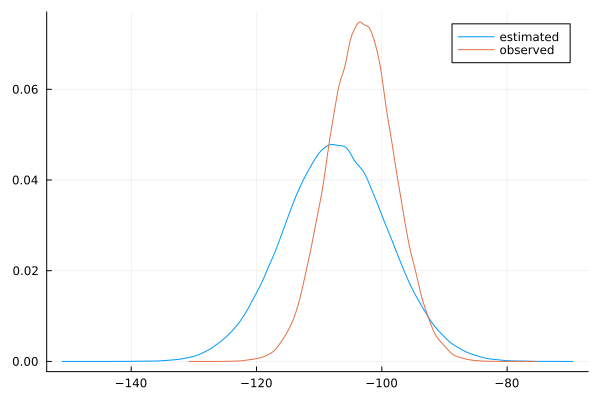

In [165]:
re_simulated_data = [mymodel(;mean(mm.chains[2])...) for i in 1:100000]
@show calculate_moments(observed_data)
@show calculate_moments(re_simulated_data)
density(re_simulated_data, label="estimated")
density!(observed_data, label="observed")

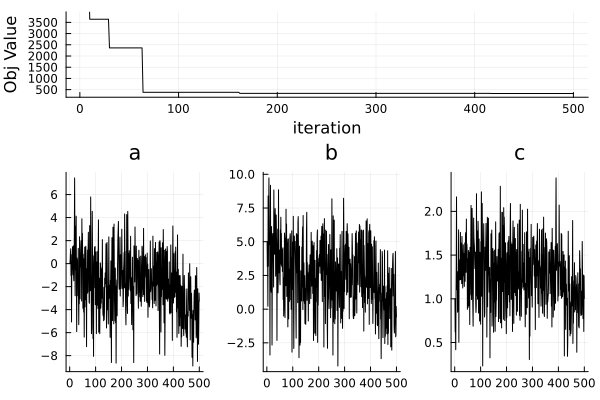

In [160]:
plot(mm.chains[2])

In [150]:
mm_slice = doSlices(mm.m, 20);

┌ Info: slicing along a
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/slices.jl:260
┌ Info: slicing along b
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/slices.jl:260
┌ Info: slicing along c
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/slices.jl:260
┌ Info: done after 0.0 minutes
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/slices.jl:287


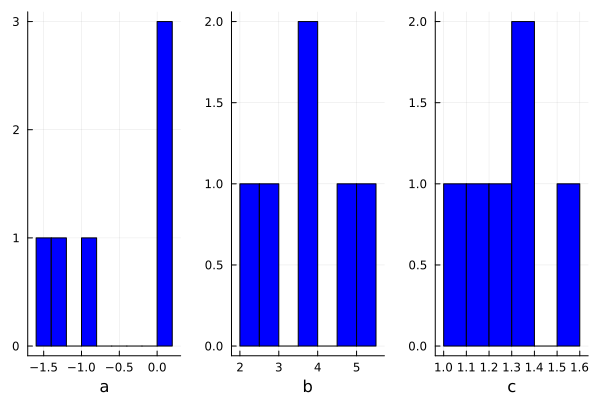

In [151]:
histogram(mm.chains[1], bins=10)

## Built-in SMM Diagnostics

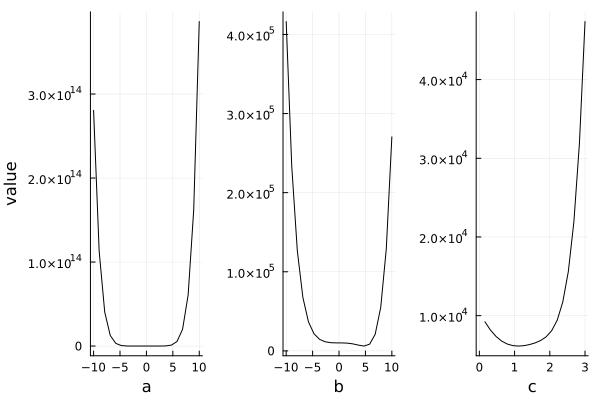

In [152]:
plot(mm_slice, :value)

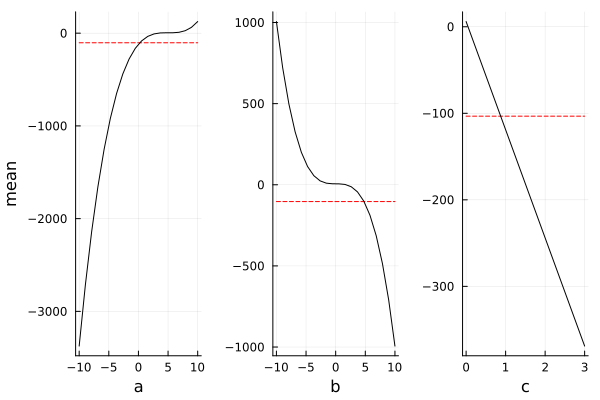

In [153]:
plot(mm_slice, :mean)

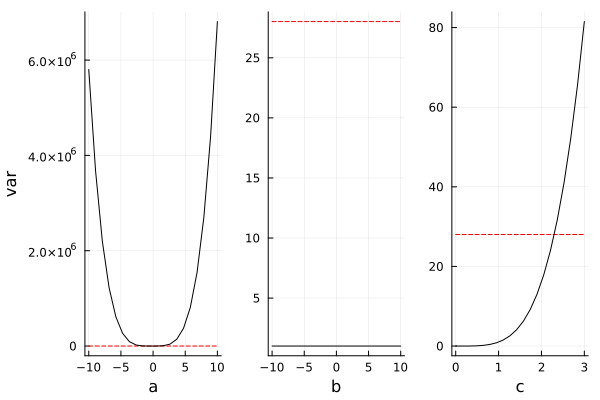

In [154]:
plot(mm_slice, :var)

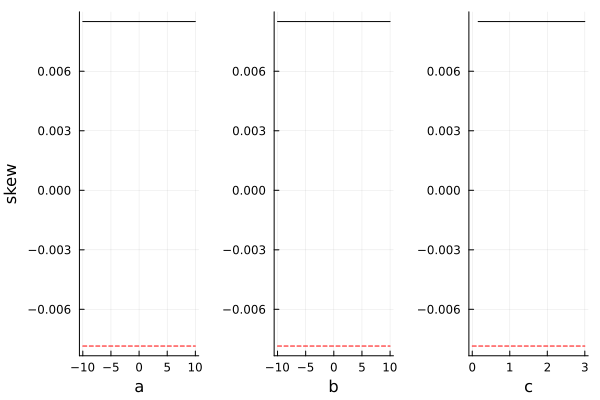

In [155]:
plot(mm_slice, :skew)

old SMM

In [68]:
function parallelNormal(niter=200)
    # data are generated from a bivariate normal
    # with mu = [a,b] = [0,0]
    # aim: 
    # 1) sample [a',b'] from a space [-3,3] x [-2,2] and
    # 2) find true [a,b] by computing distance(S([a',b']), S([a,b]))
    #    and accepting/rejecting [a',b'] according to BGP
    # 3) S([a,b]) returns a summary of features of the data: 2 means

    # initial value
    pb    = OrderedDict("p1" => [0.2,-3,3] , "p2" => [-0.2,-2,2] )
    moms = DataFrame(name=["mu1","mu2"],value=[-1.0,1.0],weight=ones(2))
    mprob = MProb() 
    addSampledParam!(mprob,pb) 
    addMoment!(mprob,moms) 
    addEvalFunc!(mprob,my_objfunc_norm)

    nchains = 3

    opts = Dict("N"=>nchains,
        "maxiter"=>niter,
        "maxtemp"=> 5,
            # choose inital sd for each parameter p
            # such that Pr( x \in [init-b,init+b]) = 0.975
            # where b = (p[:ub]-p[:lb])*opts["coverage"] i.e. the fraction of the search interval you want to search around the initial value
        "coverage"=>0.025,  # i.e. this gives you a 95% CI about the current parameter on chain number 1.
        "sigma_update_steps"=>10,
        "sigma_adjust_by"=>0.01,
        "smpl_iters"=>1000,
        "parallel"=>true,
        "min_improve"=>[0.05 for i in 1:nchains],
        "mixprob"=>0.3,
        "acc_tuners"=>[12.0 for i in 1:nchains],
        "animate"=>false)

    # plot slices of objective function
    s = doSlices(mprob,30)
    plot(s,:value)  # plot objective function over param values
    # savefig(joinpath(dirname(@__FILE__),"slices-v.png"))
    plot(s,:mu1)  # plot value of moment :mu1 over param values
    # savefig(joinpath(dirname(@__FILE__),"/slices-m.png"))
    plot(s,:mu2)  # plot value of moment :mu2 over param values
    # savefig(joinpath(dirname(@__FILE__),"../../slices-m2.png"))

    # setup the BGP algorithm
    MA = MAlgoBGP(mprob,opts)

    # run the estimation
    run!(MA)
    @show SMM.summary(MA)

    # histogram(MA.chains[1]);
    # savefig(joinpath(dirname(@__FILE__),"../../histogram.png"))
    # plot(MA.chains[1]);
    # savefig(joinpath(dirname(@__FILE__),"../../lines.png"))
    return MA
end


parallelNormal (generic function with 2 methods)

In [69]:
MA = parallelNormal()

┌ Info: slicing along p1
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/slices.jl:260
┌ Info: slicing along p2
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/slices.jl:260
┌ Info: done after 0.0 minutes
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/slices.jl:287
┌ Info: Starting estimation loop.
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/AlgoAbstract.jl:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


SMM.summary(MA) = 3×5 DataFrame
│ Row │ id    │ acc_rate │ perc_exchanged │ exchanged_most_with │ best_val   │
│     │ Int64 │ Float64  │ Float64        │ Int64               │ Float64    │
├─────┼───────┼──────────┼────────────────┼─────────────────────┼────────────┤
│ 1   │ 1     │ 0.513812 │ 9.5            │ 2                   │ 2.6619e-5  │
│ 2   │ 2     │ 0.215116 │ 14.0           │ 1                   │ 5.96299e-5 │
│ 3   │ 3     │ 0.183784 │ 7.5            │ 2                   │ 0.0210517  │


┌ Warning: could not find 'filename' in algo.opts
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/AlgoAbstract.jl:67
┌ Info: Done with estimation after 1.0 minutes
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/AlgoAbstract.jl:70



BGP Algorithm with 3 BGPChains

Algorithm
---------
Current iteration: 200
Number of params to estimate: 2
Number of moments to match: 2



In [70]:
s = doSlices(MA.m, 30)

┌ Info: slicing along p1
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/slices.jl:260
┌ Info: slicing along p2
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/slices.jl:260
┌ Info: done after 0.0 minutes
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/slices.jl:287


SMM.Slice(Dict{Symbol, Dict{Any, Any}}(:p2 => Dict(0.896551724137931 => Dict{Symbol, Any}(:value => 0.7111048453736866, :moments => OrderedDict(:mu1 => 0.18856060007194259, :mu2 => 0.9023609161042732)), -1.5862068965517242 => Dict{Symbol, Any}(:value => 4.035564306936421, :moments => OrderedDict(:mu1 => 0.18856060007194259, :mu2 => -1.5803977045853734)), -0.896551724137931 => Dict{Symbol, Any}(:value => 2.4937918115030007, :moments => OrderedDict(:mu1 => 0.18856060007194259, :mu2 => -0.8907425321715873)), -1.7241379310344827 => Dict{Symbol, Any}(:value => 4.400993716843588, :moments => OrderedDict(:mu1 => 0.18856060007194259, :mu2 => -1.7183287390681428)), -0.7586206896551724 => Dict{Symbol, Any}(:value => 2.242512223236768, :moments => OrderedDict(:mu1 => 0.18856060007194259, :mu2 => -0.75281149768883)), -0.20689655172413793 => Dict{Symbol, Any}(:value => 1.4276435729066623, :moments => OrderedDict(:mu1 => 0.18856060007194259, :mu2 => -0.20108735975779374)), -1.1724137931034482 => Dic

## Built-in SMM Diagnostics

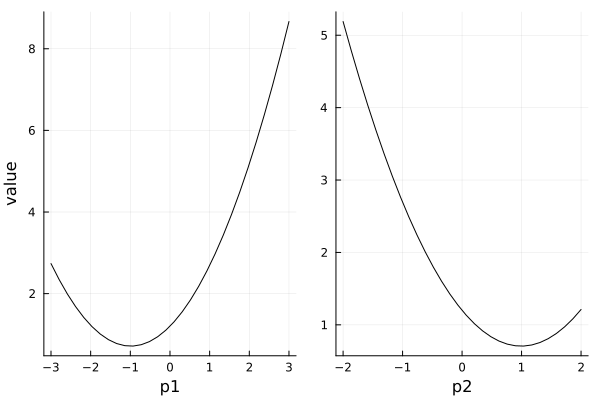

In [71]:
plot(s, :value)

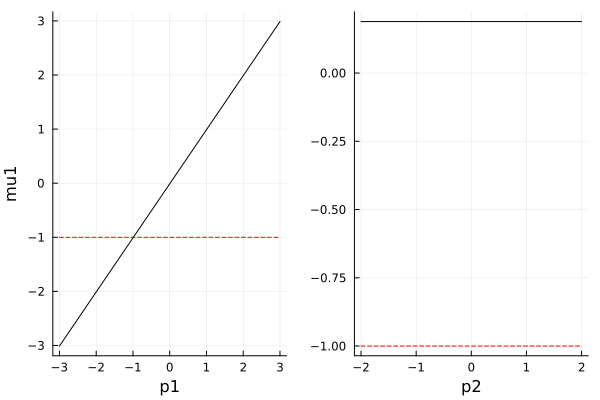

In [72]:
plot(s, :mu1)

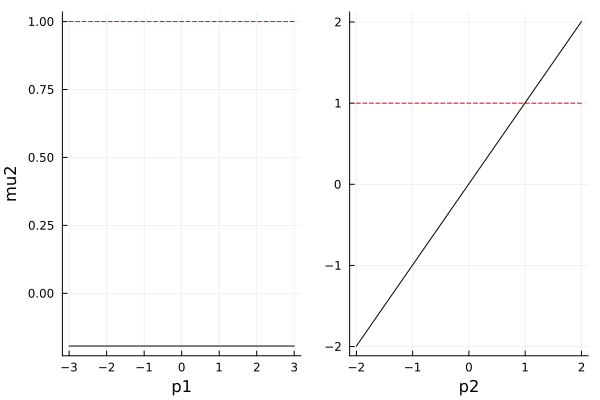

In [73]:
plot(s, :mu2)

# Chain plots

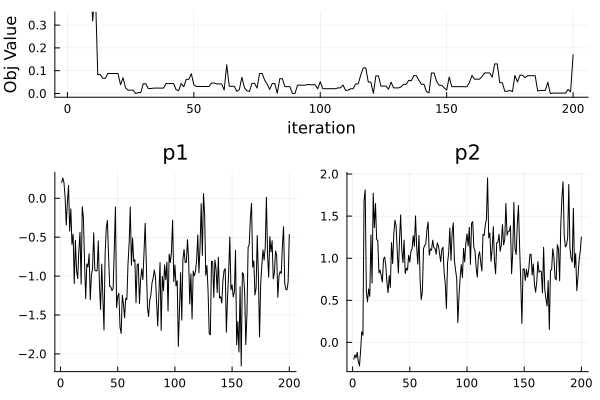

In [74]:
plot(MA.chains[1])

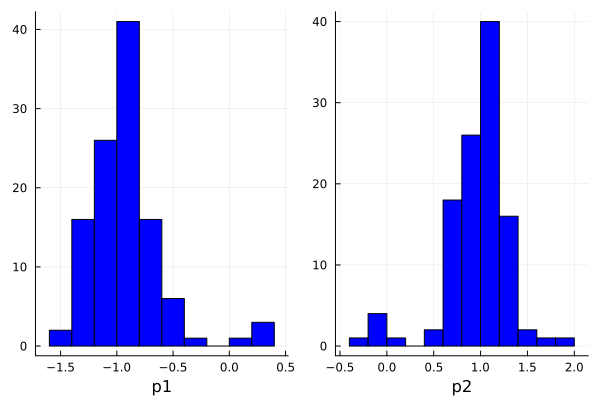

In [75]:
histogram(MA.chains[1])

## Parameter Distributions

In [76]:
p = plot(title="p1")
for (i, c) in enumerate(MA.chains)
    ps = params(c)
    density!(ps[:p1], bins=10, label="chain $i")
end
p

LoadError: UndefVarError: params not defined

In [77]:
p = plot(title="p2")
for (i, c) in enumerate(MA.chains)
    density!(params(c)[:p2], bins=10, label="chain $i")
end
p

LoadError: UndefVarError: params not defined

## Trajectories

In [78]:
p = plot(title="p1 trajectories")
for (i, c) in enumerate(MA.chains)
    df = DataFrame(params(c))
    n = nrow(df)
    w_ini = 2
    w_fin = 0.1
    lw = range(w_ini, w_fin, length=n)
    @df df plot!(:p1, label="chain $i")
end
p

LoadError: UndefVarError: params not defined

In [79]:
p = plot(title="p2 trajectories")
for (i, c) in enumerate(MA.chains)
    df = DataFrame(params(c))
    n = nrow(df)
    w_ini = 2
    w_fin = 0.1
    lw = range(w_ini, w_fin, length=n)
    @df df plot!(:p2, label="chain $i")
end
p

LoadError: UndefVarError: params not defined

In [80]:
pb    = OrderedDict("p1" => [0.2,-3,3] , "p2" => [-0.2,-2,2] )  # param spaces
moms  = DataFrame(name=["mu1","mu2"],value=[-1.0,1.0],weight=ones(2))  # truth
mprob = MProb()
addSampledParam!(mprob,pb)
addMoment!(mprob,moms)
addEvalFunc!(mprob,objfunc_norm)

nchains = 3

opts = Dict("N"=>nchains,
    "maxiter"=> 10,
    "maxtemp"=> 5,
    "coverage"=>0.025,
    "sigma_update_steps"=>10,
    "sigma_adjust_by"=>0.01,
    "smpl_iters"=>1000,
    "parallel"=>true,
    "min_improve"=>[0.05 for i in 1:nchains],
    "mixprob"=>0.3,
    "acc_tuners"=>[12.0 for i in 1:nchains],
    "animate"=>false)

MA = MAlgoBGP(mprob,opts)

run!(MA)

SMM.summary(MA)


┌ Info: Starting estimation loop.
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/AlgoAbstract.jl:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
┌ Warning: could not find 'filename' in algo.opts
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/AlgoAbstract.jl:67
┌ Info: Done with estimation after 0.0 minutes
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/AlgoAbstract.jl:70


,id,acc_rate,perc_exchanged,exchanged_most_with,best_val
,Int64,Float64,Float64,Int64,Float64
1,1,0.5,20.0,2,0.0125127
2,2,0.4,50.0,3,0.168266
3,3,0.333333,40.0,2,0.168266


In [81]:
pb    = OrderedDict("p1" => [0.2,-3,3] , "p2" => [-0.2,-2,2] )  # param spaces
moms  = DataFrame(name=["mu1","mu2"],value=[-1.0,1.0],weight=ones(2))  # truth
mprob = MProb()
addSampledParam!(mprob,pb)
addMoment!(mprob,moms)
addEvalFunc!(mprob,objfunc_norm)

nchains = 3

opts = Dict("N"=>nchains,
    "maxiter"=> 10,
    "maxtemp"=> 5,
    "coverage"=>0.025,
    "sigma_update_steps"=>10,
    "sigma_adjust_by"=>0.01,
    "smpl_iters"=>1000,
    "parallel"=>true,
    "min_improve"=>[0.05 for i in 1:nchains],
    "mixprob"=>0.3,
    "acc_tuners"=>[12.0 for i in 1:nchains],
    "animate"=>false)

MA = MAlgoBGP(mprob,opts)

run!(MA)

SMM.summary(MA)


┌ Info: Starting estimation loop.
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/AlgoAbstract.jl:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
┌ Warning: could not find 'filename' in algo.opts
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/AlgoAbstract.jl:67
┌ Info: Done with estimation after 0.0 minutes
└ @ SMM /home/oliver/.julia/packages/SMM/MDWS3/src/mopt/AlgoAbstract.jl:70


,id,acc_rate,perc_exchanged,exchanged_most_with,best_val
,Int64,Float64,Float64,Int64,Float64
1,1,0.666667,50.0,2,0.110254
2,2,0.285714,30.0,1,0.430601
3,3,0.571429,40.0,2,0.414381
